이 프로젝트의 basemodel 은 Light GBM 이다. 

- LightGBM is a gradient boosting framework that uses tree based learning algorithms. 
    - It is designed to be distributed and efficient with the following advantages:

         - Faster training speed and higher efficiency.
         - Lower memory usage.
         - Better accuracy.
         - Support of parallel and GPU learning.
         - Capable of handling large-scale data.
         
These are why we choose this model about this topic and let us we introduce our basemodel 

In [1]:
# package
import numpy as np 
import pandas as pd 
import os
import json
from pandas.io.json import json_normalize
import ast
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook
from scipy.stats import skew, boxcox
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from mpl_toolkits.mplot3d import Axes3D
import ast
import re
import yaml
import json
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import eli5
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import warnings  
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# method
def date_features(df):
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
    # 연도 끝 두자리수만 있기 때문에 앞에 19/20 붙이기
    df.loc[ (train['release_year'] <= 19) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (train['release_year'] > 19) & (df['release_year'] < 100), "release_year"] += 1900
    return df

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [3]:
# Loading dataset
submission_path = "C:/Users/domin/Desktop/data/tmdb-box-office-prediction/sample_submission.csv"
train_path = "C:/Users/domin/Desktop/data/tmdb-box-office-prediction/train.csv"
test_path = "C:/Users/domin/Desktop/data/tmdb-box-office-prediction/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sam_sub = pd.read_csv(submission_path)
print( "train dataset:", train.shape,"\n","test dataset: ",test.shape,"\n","sample_submission dataset:", sam_sub .shape)

train dataset: (3000, 23) 
 test dataset:  (4398, 22) 
 sample_submission dataset: (4398, 2)


In [4]:
# dataset 살펴보기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

# 2.1 **Data Pre-processing & EDA**

## date_features 

In [6]:
train = date_features(train)
test = date_features(test)

## 범주형 변수 변환

## **Json Format Columns to Dictionary Format**
<br>

In order to clean up the Json format columns, I am going to convert these columns to the dictionary format and analyze each column.

In [7]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

train = text_to_dict(train)
test = text_to_dict(test)

## **Belong_to collection**

In [8]:
# Counting NAs as 0
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [9]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

## **Genres**
<br>
Many genres of movies are drama and comedy in the train data. I am going to conduct text analysis on movie titles by genre and revenue comparison over years by genres.

In [10]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

## **production_companies**

In [11]:
train['num_production_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_production_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

train = train.drop(['production_companies'], axis=1)
test = test.drop(['production_companies'], axis=1)

## **production_countries**

In [12]:
train['num_production_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_production_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

train = train.drop(['production_countries'], axis=1)
test = test.drop(['production_countries'], axis=1)

## **Cast**

In [13]:
# list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['all_cast'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
test['all_cast'] = test['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')


train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

## **Crew**

In [14]:
# list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
train['all_crew'] = train['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
test['all_crew'] = test['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

## **spoken_languages**

In [15]:
# list_of_spokenlanguage_names = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_spoken_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_spoken_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_spoken_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_spoken_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

train = train.drop(['spoken_languages'], axis=1)
test = test.drop(['spoken_languages'], axis=1)

## **keyword**

In [16]:
# list_of_Keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')


train = train.drop(['Keywords'], axis=1)
test = test.drop(['Keywords'], axis=1)

## **Missing data**
<br>

## **homepage**
- 유/무

In [17]:
train['has_homepage'] = 1
train.loc[pd.isnull(train['homepage']) ,"has_homepage"] = 0
test['has_homepage'] = 1
test.loc[pd.isnull(test['homepage']) ,"has_homepage"] = 0

train = train.drop(['homepage'], axis=1)
test = test.drop(['homepage'], axis=1)

## **tagline**
- 유/무

In [18]:
train['isTaglineNA'] = 0
train.loc[pd.isnull(train['tagline']) ,"isTaglineNA"] = 1
test['isTaglineNA'] = 0
test.loc[pd.isnull(test['tagline']) ,"isTaglineNA"] = 1

train = train.drop(['tagline'], axis=1)
test = test.drop(['tagline'], axis=1)

## **original, title**

In [19]:
train['isTitleDifferent'] = 1
train.loc[ train['original_title'] == train['title'] ,"isTitleDifferent"] = 0
test['isTitleDifferent'] = 1
test.loc[ test['original_title'] == test['title'] ,"isTitleDifferent"] = 0

train = train.drop(['original_title', 'title'], axis=1)
test = test.drop(['original_title', 'title'], axis=1)

# **2.2. FE(Feature Enginering)**

## **연속형 변수 변환**

#### revenue

Skew of revenue attribute: 4.5


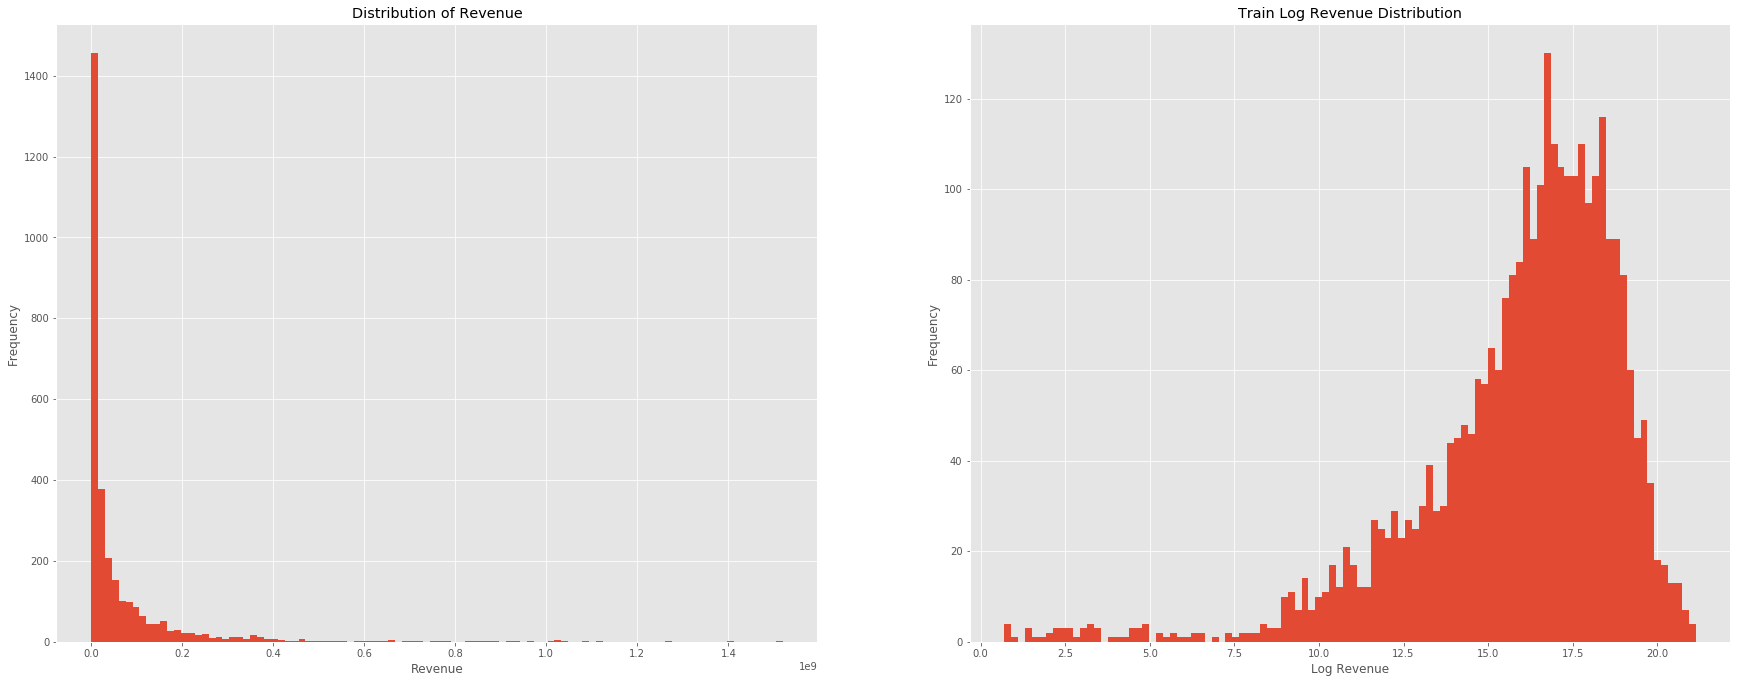

In [20]:
#### Plot the distribution of the revenue

fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['revenue'].plot(kind='hist',bins=100)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')

plt.subplot(222)
np.log1p(train['revenue']).plot(kind='hist',bins=100)
plt.title('Train Log Revenue Distribution')
plt.xlabel('Log Revenue')

# log 를 씌워 데이터의 이해를 돕기 위한 시각화

print('Skew of revenue attribute: %0.1f' % skew(train['revenue']))

Skew of budget attribute: 3.1


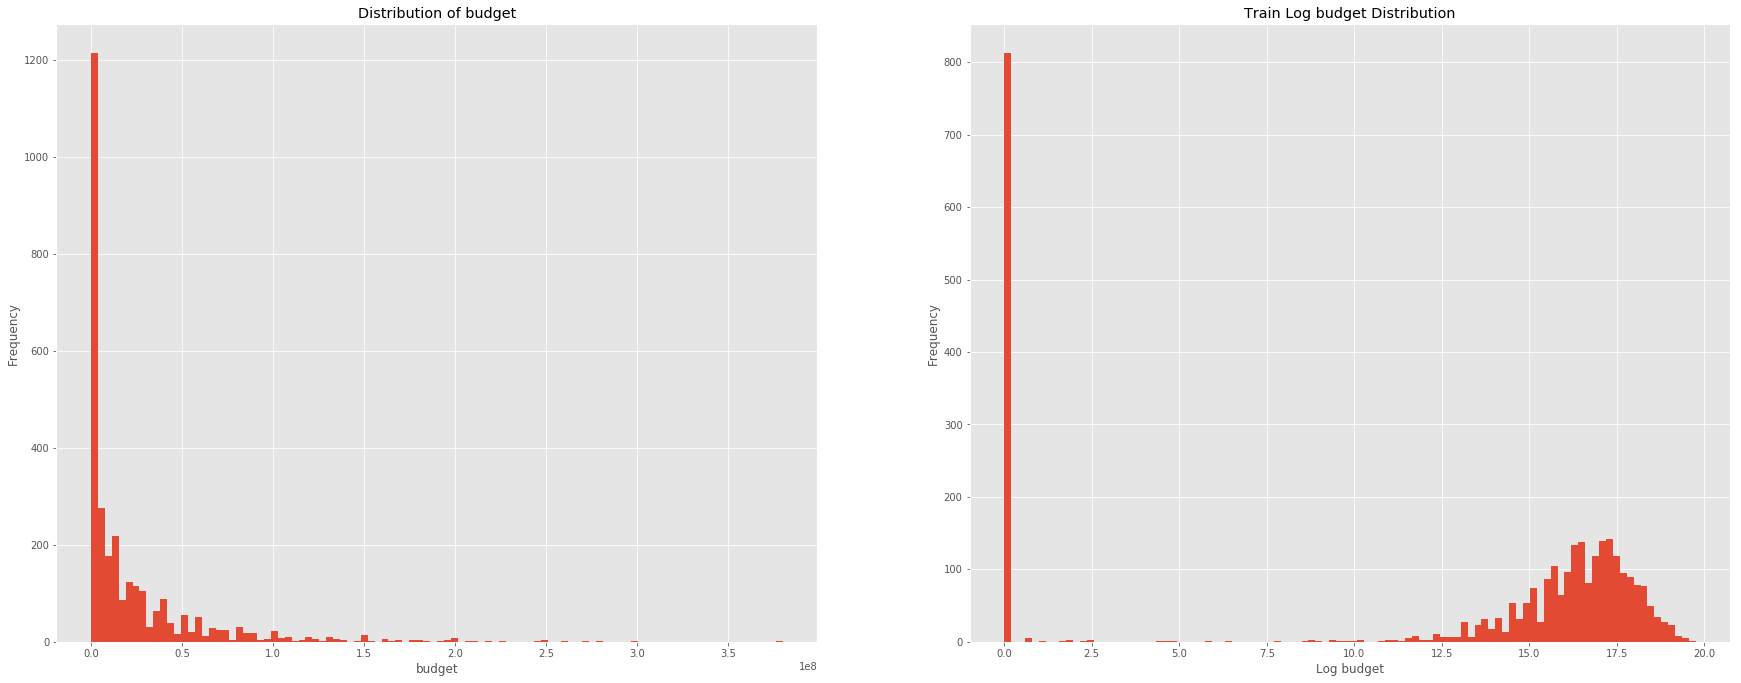

In [21]:
fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['budget'].plot(kind='hist',bins=100)
plt.title('Distribution of budget')
plt.xlabel('budget')

plt.subplot(222)
np.log1p(train['budget']).plot(kind='hist',bins=100)
plt.title('Train Log budget Distribution')
plt.xlabel('Log budget')

# log 를 씌워 데이터의 이해를 돕기 위한 시각화


print('Skew of budget attribute: %0.1f' % skew(train['budget']))

Skew of runtime attribute: nan


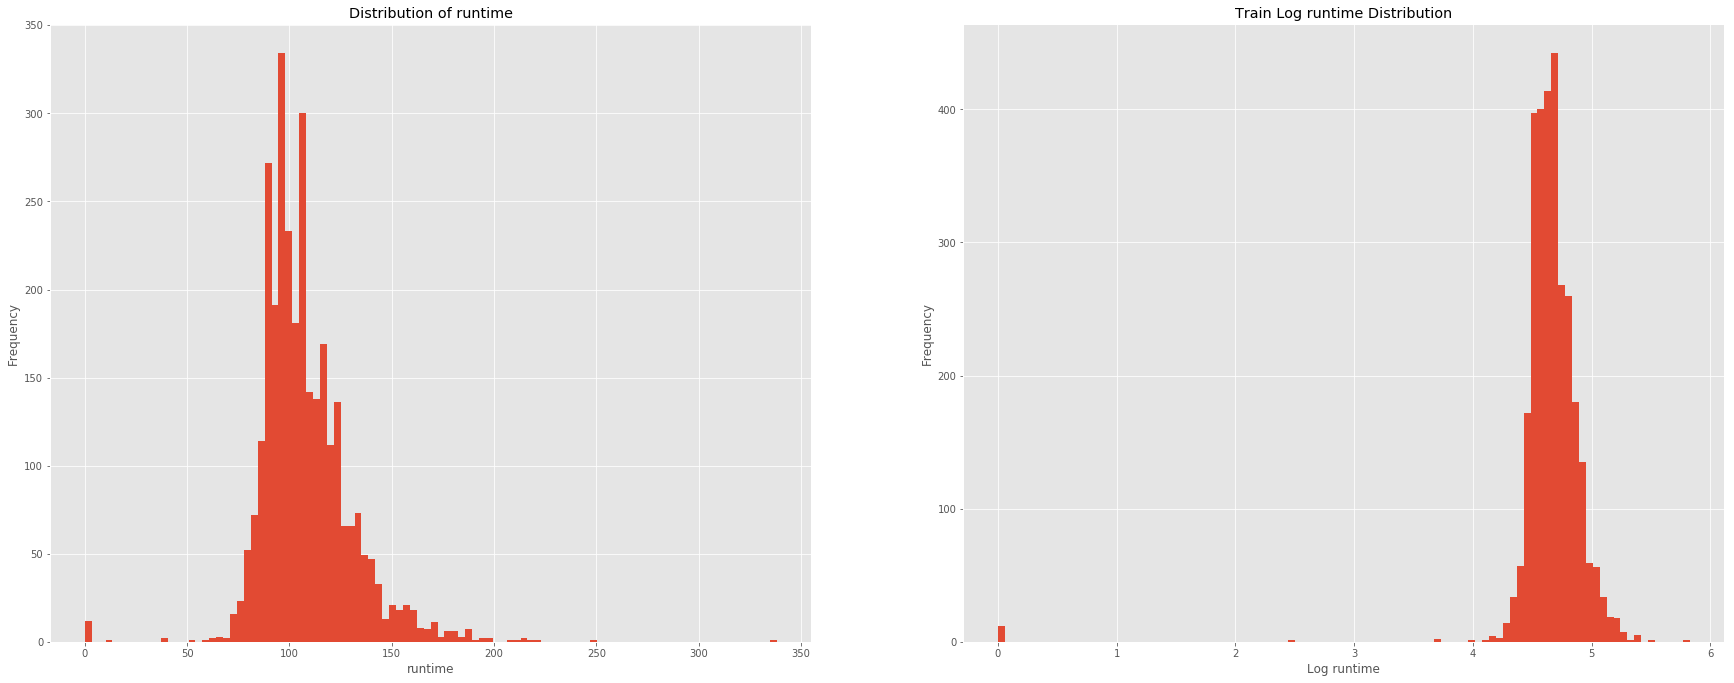

In [22]:
fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['runtime'].plot(kind='hist',bins=100)
plt.title('Distribution of runtime')
plt.xlabel('runtime')

plt.subplot(222)
np.log1p(train['runtime']).plot(kind='hist',bins=100)
plt.title('Train Log runtime Distribution')
plt.xlabel('Log runtime')

# log 를 씌워 데이터의 이해를 돕기 위한 시각화

print('Skew of runtime attribute: %0.1f' % skew(train['runtime']))

In [23]:
# Putting log variables for skewed data 
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])
train = train.drop(['budget'], axis=1)
test = test.drop(['budget'], axis=1)

# **3. Data modeling**

In [24]:
# Formating for modeling

used_features = ['release_year', 'num_genres', 'all_genres',
       'num_production_companies', 'all_production_companies',
       'num_production_countries', 'all_production_countries', 'num_cast',
       'all_cast', 'num_crew', 'all_crew', 'num_spoken_languages',
       'all_spoken_languages', 'num_Keywords', 'all_Keywords', 'has_homepage',
       'isTaglineNA', 'isTitleDifferent', 'log_budget']

X = train[used_features]
y = np.log1p(train['revenue'])
 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# base model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

print("훈련 점수: {:.2f}".format(xgb_model.score(X_train, y_train)))
print("테스트 점수: {:.2f}".format(xgb_model.score(X_test, y_test)))

eli5.show_weights(xgb_model, feature_filter=lambda x: x != '<BIAS>')

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields all_genres, all_production_companies, all_production_countries, all_cast, all_crew, all_spoken_languages, all_Keywords